C:\Users\tomsm\PycharmProjects\thesis\results\simclr_graph


In [20]:
from utils.helper_functions import load_model, prepare_data_features
from models.simclr_model import SimCLR
from models.supervised_model import SupervisedModel
from datasets.SHHS_dataset_timeonly import SHHS_dataset_1
import torch.utils.data as data
from copy import deepcopy
import torch.nn as nn
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
encoder_path = "../../trained_models/cnn_simclr_500pat.ckpt"
pretrained_model = load_model(SimCLR, encoder_path)  # Load pretrained simclr model

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
  rank_zero_warn(


In [24]:
test_ds = SHHS_dataset_1(data_path='../../../thesis01/data/',
                             first_patient=1,
                             num_patients=30)
test_dl = data.DataLoader(dataset=test_ds,
                              batch_size=64,
                              shuffle=False,
                              num_workers=12)

Couldn't find file at path:  ../../../thesis01/data/n0014_eeg.mat


In [31]:
device = 'cpu'
test_features_ds = prepare_data_features(model=pretrained_model,
                                             data_loader=test_dl,
                                             device=device)

test_features_dl = data.DataLoader(dataset=test_ds,
                                   batch_size=64,
                                   shuffle=False,
                                   num_workers=12)

  0%|          | 0/444 [00:00<?, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 376 nearest neighbors...
[t-SNE] Indexed 28353 samples in 0.000s...
[t-SNE] Computed neighbors for 28353 samples in 18.121s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28353
[t-SNE] Computed conditional probabilities for sample 2000 / 28353
[t-SNE] Computed conditional probabilities for sample 3000 / 28353
[t-SNE] Computed conditional probabilities for sample 4000 / 28353
[t-SNE] Computed conditional probabilities for sample 5000 / 28353
[t-SNE] Computed conditional probabilities for sample 6000 / 28353
[t-SNE] Computed conditional probabilities for sample 7000 / 28353
[t-SNE] Computed conditional probabilities for sample 8000 / 28353
[t-SNE] Computed conditional probabilities for sample 9000 / 28353
[t-SNE] Computed conditional probabilities for sample 10000 / 28353
[t-SNE] Computed conditional probabilities for sample 11000 / 28353
[t-SNE] Computed conditional probabilities for sample 12000 / 28353
[t-SNE] Computed conditional probabilities for s

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

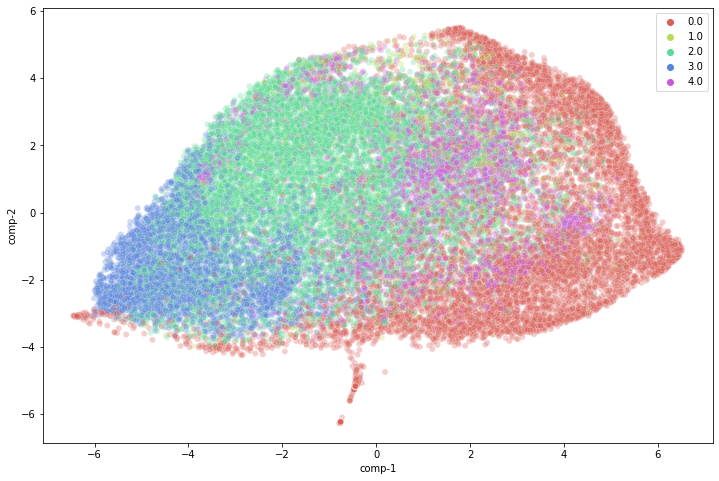

In [32]:
tsne = TSNE(n_components=2, n_iter=300, verbose=1, perplexity=125)
x, y = test_features_ds.tensors
tsne_results = tsne.fit_transform(x)
df = pd.DataFrame()
df['comp-1'] = tsne_results[:,0]
df['comp-2'] = tsne_results[:,1]
df["y"] = y
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)

In [18]:
ckpt_path = "../../trained_sup.ckpt"
sup_model = load_model(SupervisedModel, ckpt_path)
sup_model

SupervisedModel(
  (encoder): CNN_head(
    (model): Sequential(
      (0): CNN_block(
        (net): Sequential(
          (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=same, bias=False)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): CNN_block(
        (net): Sequential(
          (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (2): CNN_block(
        (net): Sequential(
          (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [26]:
next(iter(test_dl))[0].shape

torch.Size([64, 1, 1, 3000])

In [27]:
network = deepcopy(sup_model.encoder)
network.g = nn.Identity()  # Removing projection head g(.)
network.eval()
network.to(device)

# Encode all images
feats, labels = [], []
for batch_inputs, batch_labels in test_dl:
    batch_inputs = batch_inputs.to(device)
    batch_feats = network(batch_inputs.squeeze(dim=1))
    feats.append(batch_feats.detach().cpu())
    labels.append(batch_labels)

feats = torch.cat(feats, dim=0)
labels = torch.cat(labels, dim=0)

test_features_ds_sup = data.TensorDataset(feats, labels)
test_features_dl_sup = data.DataLoader(dataset=test_features_ds,
                                       batch_size=64,
                                       shuffle=False,
                                       num_workers=12)

In [28]:
tsne = TSNE(n_components=2, n_iter=300, verbose=1, perplexity=125)
x, y = test_features_ds_sup.tensors
tsne_results = tsne.fit_transform(x)

C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 376 nearest neighbors...
[t-SNE] Indexed 28353 samples in 0.002s...
[t-SNE] Computed neighbors for 28353 samples in 18.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28353
[t-SNE] Computed conditional probabilities for sample 2000 / 28353
[t-SNE] Computed conditional probabilities for sample 3000 / 28353
[t-SNE] Computed conditional probabilities for sample 4000 / 28353
[t-SNE] Computed conditional probabilities for sample 5000 / 28353
[t-SNE] Computed conditional probabilities for sample 6000 / 28353
[t-SNE] Computed conditional probabilities for sample 7000 / 28353
[t-SNE] Computed conditional probabilities for sample 8000 / 28353
[t-SNE] Computed conditional probabilities for sample 9000 / 28353
[t-SNE] Computed conditional probabilities for sample 10000 / 28353
[t-SNE] Computed conditional probabilities for sample 11000 / 28353
[t-SNE] Computed conditional probabilities for sample 12000 / 28353
[t-SNE] Computed conditional probabilities for s

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

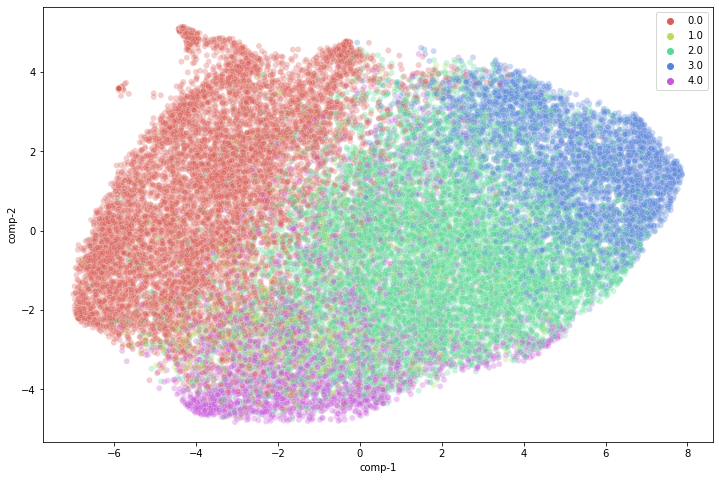

In [30]:
df = pd.DataFrame()
df['comp-1'] = tsne_results[:,0]
df['comp-2'] = tsne_results[:,1]
df["y"] = y
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)